<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/baseline_second_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#code inspired from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [2]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement catalyst==22.04rc1 (from versions: 19.1rc0, 19.1rc1, 19.1rc2, 19.2rc0, 19.3rc0, 19.3, 19.4rc0, 19.4rc1, 19.4rc2, 19.4rc3, 19.5, 19.6rc1, 19.6rc2, 19.6rc3, 19.6rc4, 19.6, 19.6.1, 19.6.2, 19.6.3, 19.6.4, 19.6.5, 19.7, 19.7.1, 19.7.2, 19.7.3, 19.7.4, 19.8, 19.8.1, 19.8.3, 19.8.4, 19.8.5, 19.8.6, 19.8.7, 19.8.8, 19.9, 19.9.1, 19.9.2, 19.9.3, 19.9.4, 19.9.5, 19.10, 19.10.1, 19.10.2, 19.11, 19.11.1, 19.11.2, 19.11.3, 19.11.4, 19.11.5, 19.11.6, 19.12, 19.12.1, 19.12.2, 19.12.3, 20.1, 20.1.1, 20.1.3, 20.2, 20.2.1, 20.2.2, 20.2.3, 20.2.4, 20.3, 20.3.1, 20.3.2, 20.3.3, 20.4, 20.4.1, 20.4.2, 20.5, 20.5.1, 20.6rc1, 20.6, 20.7, 20.8.1, 20.8.2, 20.9, 20.9.1, 20.10, 20.10.1, 20.11, 20.12, 21.1rc0, 21.2rc0, 21.3, 21.3.1, 21.3.2, 21.4, 21.4.1, 21.4.2, 21.5, 21.6, 21.7, 21.8, 21.9rc0, 21.9rc1, 21.9, 21.10, 21.11, 21.12, 22.2rc0, 22.2, 22.2.1, 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

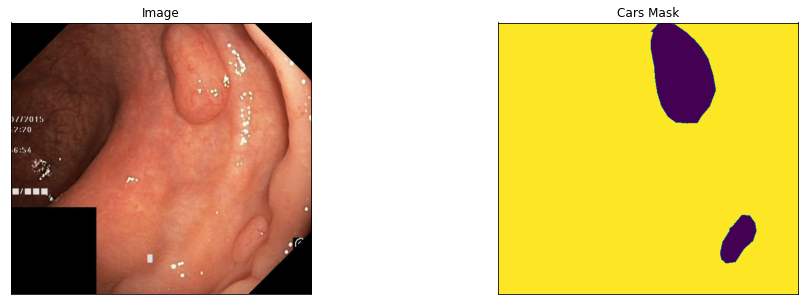

In [10]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

In [11]:
import albumentations as albu

In [12]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        #albu.Resize(576, 736)
        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import catalyst

In [15]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['polyp', 'background']
ACTIVATION = 'sigmoid'

In [16]:
# create segmentation model with pretrained encoder
model = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going 

## Training

In [24]:
import torch
import torch.nn as nn
from catalyst.runners import SupervisedRunner
#from catalyst.experiments import SupervisedRunner
# experiment setup
num_epochs = 10  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
#metrics = [
#     smp.  metrics.iou_score() 
     #IoUMetric(eps=1.),
     #smp.utils.metrics.FscoreMetric(eps=1.),
#]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


1/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (1/10) loss: 0.5508997076749803 | loss/mean: 0.5508997076749803 | loss/std: 0.04271805380200548 | lr: 0.0001 | momentum: 0.9


1/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (1/10) loss: 0.5286004692316054 | loss/mean: 0.5286004692316054 | loss/std: 0.11748843343034743 | lr: 0.0001 | momentum: 0.9
* Epoch (1/10) 


2/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (2/10) loss: 0.5275063413381575 | loss/mean: 0.5275063413381575 | loss/std: 0.03275398031271845 | lr: 0.0001 | momentum: 0.9


2/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (2/10) loss: 0.5272547554969788 | loss/mean: 0.5272547554969788 | loss/std: 0.12381967237394204 | lr: 0.0001 | momentum: 0.9
* Epoch (2/10) 


3/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (3/10) loss: 0.5256887412071226 | loss/mean: 0.5256887412071226 | loss/std: 0.036126742406838934 | lr: 0.0001 | momentum: 0.9


3/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (3/10) loss: 0.5124505734443665 | loss/mean: 0.5124505734443665 | loss/std: 0.1207442206915214 | lr: 0.0001 | momentum: 0.9
* Epoch (3/10) 


4/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (4/10) loss: 0.5177480161190032 | loss/mean: 0.5177480161190032 | loss/std: 0.04410558763347259 | lr: 0.0001 | momentum: 0.9


4/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (4/10) loss: 0.5059907186031343 | loss/mean: 0.5059907186031343 | loss/std: 0.1224749347148586 | lr: 0.0001 | momentum: 0.9
* Epoch (4/10) 


5/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (5/10) loss: 0.5179704892635347 | loss/mean: 0.5179704892635347 | loss/std: 0.04066062050676426 | lr: 0.0001 | momentum: 0.9


5/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (5/10) loss: 0.516334171295166 | loss/mean: 0.516334171295166 | loss/std: 0.13573254199606438 | lr: 0.0001 | momentum: 0.9
* Epoch (5/10) 


6/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (6/10) loss: 0.5114010566473006 | loss/mean: 0.5114010566473006 | loss/std: 0.03959709342276507 | lr: 0.0001 | momentum: 0.9


6/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (6/10) loss: 0.5039123940467833 | loss/mean: 0.5039123940467833 | loss/std: 0.12160364472850756 | lr: 0.0001 | momentum: 0.9
* Epoch (6/10) 


7/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (7/10) loss: 0.5149449646472929 | loss/mean: 0.5149449646472929 | loss/std: 0.04087435099054353 | lr: 0.0001 | momentum: 0.9


7/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (7/10) loss: 0.5052890008687974 | loss/mean: 0.5052890008687974 | loss/std: 0.12070817724522816 | lr: 0.0001 | momentum: 0.9
* Epoch (7/10) 


8/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (8/10) loss: 0.5146869909763335 | loss/mean: 0.5146869909763335 | loss/std: 0.040339872882595496 | lr: 0.0001 | momentum: 0.9


8/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (8/10) loss: 0.5002191996574403 | loss/mean: 0.5002191996574403 | loss/std: 0.10919332561149302 | lr: 0.0001 | momentum: 0.9
* Epoch (8/10) 


9/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (9/10) loss: 0.5070847219228745 | loss/mean: 0.5070847219228745 | loss/std: 0.04765962578543568 | lr: 0.0001 | momentum: 0.9


9/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (9/10) loss: 0.498446152806282 | loss/mean: 0.498446152806282 | loss/std: 0.12817242404852056 | lr: 0.0001 | momentum: 0.9
* Epoch (9/10) 


10/10 * Epoch (train):   0%|          | 0/100 [00:00<?, ?it/s]

train (10/10) loss: 0.5031170469522477 | loss/mean: 0.5031170469522477 | loss/std: 0.036655828830213795 | lr: 0.0001 | momentum: 0.9


10/10 * Epoch (valid):   0%|          | 0/100 [00:00<?, ?it/s]

valid (10/10) loss: 0.49067124366760256 | loss/mean: 0.49067124366760256 | loss/std: 0.12943690937675054 | lr: 0.0001 | momentum: 0.9
* Epoch (10/10) 
Top models:
./logs/segmentation_notebook/checkpoints/model.0010.pth	10.0000
